# Inleveropdracht 3: Vector Space Models & Principle Component Analysis
#### Naam: Lucas van der Horst
#### Studentnummer: 1757028

## Deel I: Vector Space Models

1. Start een nieuwe notebook en importeer Numpy, Pandas, Pickle en Pyplotlib.

In [1]:
from typing import Tuple, List
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

2. Lees het bestand capitals.txt Download capitals.txtin in een dataframe, zet de columns op `['city1', 'country1', 'city2', 'country2']`

In [2]:
capitals_df = pd.read_csv('capitals.txt', sep=' ', names=['city1', 'country1', 'city2', 'country2'])
capitals_df.head()

city1 country1    city2     country2
0  Athens   Greece  Baghdad         Iraq
1  Athens   Greece  Bangkok     Thailand
2  Athens   Greece  Beijing        China
3  Athens   Greece   Berlin      Germany
4  Athens   Greece     Bern  Switzerland

3. Het bestand word_embeddings_subset.p bevat een selectie van de Google News word embedding dataset, waarin alle steden en landen uit capitals.txt voorkomen, met een 300-dimensionele vector per woord, die door machine learning zijn verkregen.  
Als je zelf de hele dataset wilt downloaden en bekijken: deze is hierLinks to an external site. te vinden.
Lees het bestand in via Pickle, dit geeft je een dictionary.  
Test de ingeladen data door de eerste paar items van de capitals file te printen en het aantal embeddings en de dimension van een de embedding van een van de ingeladen woorden.  
Er horen 243 embeddings te zijn, van dimension 300.

In [3]:
embeddings_dict = pickle.load(open('word_embeddings_subset.p', 'rb'))
print(len(embeddings_dict), "embedding vectors")
print("of dimensionality", len(tuple(embeddings_dict.values())[0]))

243 embedding vectors
of dimensionality 300


4/ Maak een functie die de cosine distance / cosine similarity tussen twee woord-vectoren berekent.  
Input:  
`A`: numpy array van een word vector  
`B`: numpy array van een word vector  
Output:  
`cos`: getal dat de cosine similarity tussen A and B aangeeft.

In [4]:
def cosine_similarity(A: np.ndarray, B: np.array) -> float:
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

def cosine_distance(A: np.ndarray, B: np.array) -> float:
    return 1 - cosine_similarity(A, B)

5. Maak een functie die de Euclidean distance tussen twee woord-vectoren berekent

In [5]:
def euclidean_distance(A: np.ndarray, B: np.array) -> float:
    return np.linalg.norm(A - B)

6. Test je functies door de embedding van de woorden `'king'` en `'queen'` te vergelijken, uit de cosine distance hoort `0.6510957` te komen, en de Euclidean distance `2.479625`.

In [6]:
word1 = "king"
word2 = "queen"
print("cosine distance:", cosine_similarity(embeddings_dict[word1], embeddings_dict[word2]))
print("euclidean distance:", euclidean_distance(embeddings_dict[word1], embeddings_dict[word2]))

cosine distance: 0.65109605
euclidean distance: 2.4796922


7. Maak een functie die gegeven twee woorden met een bepaalde relatie, van een derde woord het woord vindt dat het meest dicht bij dezelfde relatie komt, volgens de analogie: King - man + Woman => Queen.  
Geef als output het woord dat daar uitkomt en de waarde van de gevonden similarity.  
Input:  
`city1`: string, hoofdstad van `country1`  
`country1`: string, land van `capital1`  
`city2`: string, hoofdstad van een ander land  
`embeddings`: een dictionary met de woorden als keys en de embeddings van die woorden als values  
Output:  
`country`: een tuple met het land dat het meest waarschijnlijk bij city2 hoort, en zijn similarity score

In [7]:
def find_closest_embeddings(city1: str, country1: str, city2: str, embeddings: dict) -> Tuple[str, float]:
    # Compute the target embedding using the `King - Man + Woman => Queen` analogy
    target_embedding = embeddings[country1] - embeddings[city1] + embeddings[city2]
    # Reform the dictionary into a list of tuples for consistency
    words_and_embeddings = list(embeddings.items())
    # Remove the words we are comparing from the list
    words_and_embeddings = [item for item in words_and_embeddings if item[0] not in [city1, country1, city2]]
    # Compute the similarities between the target embedding and every other embedding
    similarities = np.array([cosine_similarity(target_embedding, embedding) for word, embedding in words_and_embeddings])
    # Select the one with the largest cosine similarity
    max_similarity_idx = np.argmax(similarities)
    # Return the word (not the embedding) that has the highest cosine similarity
    return words_and_embeddings[max_similarity_idx][0], similarities[max_similarity_idx]

8. Test je functie door `'Athens', 'Greece', 'Cairo'` als input te geven. De output zou dan `('Egypt', 0.7626822)` moeten zijn.

In [8]:
find_closest_embeddings("Athens", "Greece", "Cairo", embeddings_dict)

('Egypt', 0.7626827)

In [9]:
# caluculate the accuracy of the model
correct = 0
for i, (city1, country1, city2, country2) in enumerate(capitals_df.values):
    closest_word, _ = find_closest_embeddings(city1, country1, city2, embeddings_dict)
    if closest_word == country2:
        correct += 1
print(f"Accuracy: {correct / len(capitals_df):.2%}")

Accuracy: 91.92%


## Deel II: Principle Component Analysis

We schrijven in dezelfde notebook een functie om PCA op een verzameling word vectors, met deze in- en output:

Input:  
`X`: numpy matrix van dimensie (m,n), elke row is een word vector  
`n_components`: Aantal  
Output:  
`X_reduced`: De data getransformeerd naar 2 dimensies (columns)

De functie moet de volgende transformaties op de data uitvoeren:

1. Centreer de data op het gemiddelde (trek het gemiddelde van elk datapunt af) d.m.v. numpy.mean()
2. Bereken de covariance matrix van de gecentreerde data d.m.v. numpy.cov()
3. Bereken de Eigenvectors en Eigenvalues van de covariance matrix d.m.v. numpy.linalg.eigh()
4. Sorteer de Eigenvectors in volgorde van afnemende Eigenvalue (zoek zelf de juiste numpy functie)
5. Neem de eerste n Eigenvectors uit de gesorteerde array
6. Vermenigvuldig die Eigenvectors met de originele gecentreerde data uit stap 1 (transposeLinks to an external site. je matrices waar nodig).

In [10]:
def compute_pca(X: np.ndarray, n_components: int) -> np.ndarray:
    # Center the data by subtracting the mean
    X -= X.mean(axis=0)
    # Compute the covariance matrix
    cov = np.cov(X, rowvar=False)
    # Compute the eigenvalues and eigenvectors of the coveriance matrix using numpy.linalg.eigh
    eigen_values, eigen_vectors = np.linalg.eigh(cov)
    # Sort the eigenvalues and eigenvectors in descending order
    idx_sorted = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[idx_sorted]
    eigen_vectors = eigen_vectors[:, idx_sorted]
    # Select the first n eigenvectors (n is specified by n_components)
    eigen_vectors = eigen_vectors[:, :n_components]
    # Transform the data by multiplying the transpose of the eigenvectors by the transpose of the data
    X_transformed = np.dot(eigen_vectors.T, X.T).T
    return X_transformed

7. Test je functie met deze code:

In [11]:
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_pca(X, n_components=2)
print("De originele matrix is " + str(X.shape) + ", en na PCA:")
print(X_reduced)

De originele matrix is (3, 10), en na PCA:
[[ 0.43437323 -0.49820384]
 [ 0.42077249  0.50351448]
 [-0.85514571 -0.00531064]]


8. Schrijf een hulpfunctie die van een gegeven array van woorden de embeddings opzoekt en teruggeeft:  
Input:  
`embeddings`: alle beschikbare word embeddings  
`words`: een list van woorden  
Output:  
`X`: een matrix met als rows de embeddings die bij de woorden uit de gegeven list horen

In [12]:
def search_word_embeddings(embeddings: dict, words: List[str]) -> np.ndarray:
    return np.array([embeddings[word] for word in words])

9. Plot met behulp van je hulpfunctie van stap 8 de PCA in 2 dimensies, van deze woorden. Maak met pyplot een scatter plot:  
`['oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']`  
Wat valt je op aan de plaatsing van de woorden?

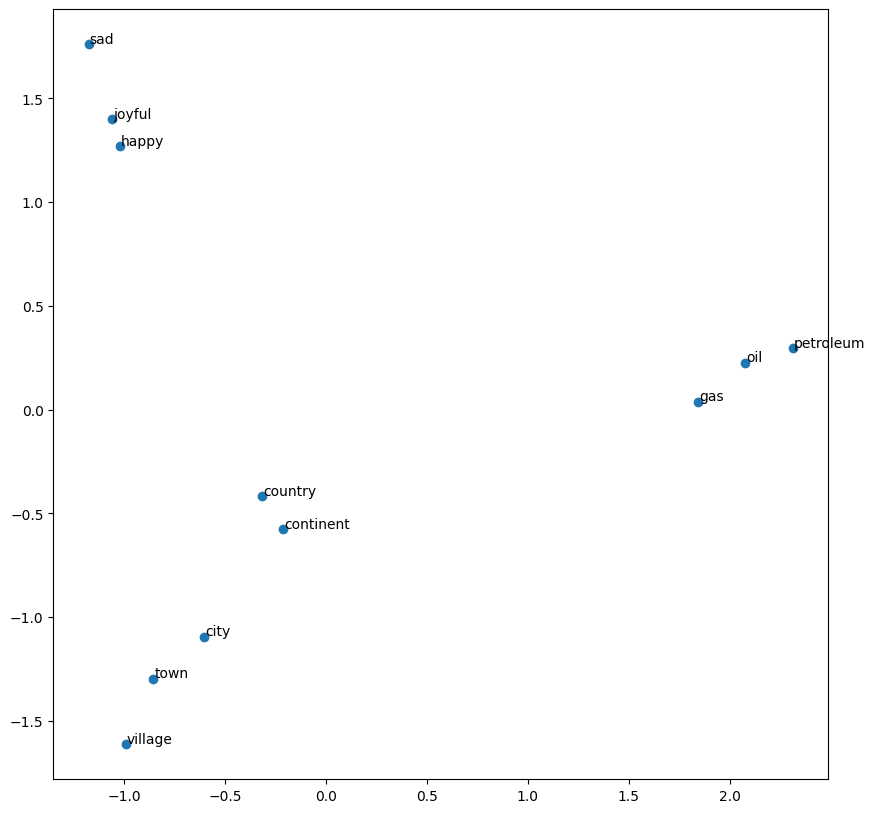

In [13]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']
X = search_word_embeddings(embeddings_dict, words)
X_reduced = compute_pca(X, n_components=2)
plt.figure(figsize=(10, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(X_reduced[i, 0] + 0.005, X_reduced[i, 1] + 0.005))
plt.show()

Het valt op dat de woorden in dezelfde catagorie dicht bij elkaar liggen. Zo lijkt er een cluster van emoties, olietermen, wereldstukken en steden te zijn. De sample size is een beetje klein maar het lijkt zelfs alsof de woorden in volgorde liggen. Zo komen 'village' eerst, dan 'town' en dan 'city'. Mogelijk kan je 'continent' en 'country' ook nog in deze volgorde plaatsen maar deze zijn een stuk verder. Hetzelfde is te zien dat dat joyful dichterbij happy ligt dan sad.